In [ ]:
import pandas as pd
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
!ls "/content/drive/My Drive"
DIR = Path.cwd() / 'drive' / 'MyDrive'
CDEC = DIR / 'dreamer_folsom' / 'data' / 'cdec'
drive = CDEC.resolve()
print(drive)
print([x.name for x in CDEC.iterdir() if x.is_file()])
# !ls drive

 admin		     c_paper	      pres      spatial_rl  'WRR outline.gdoc'
 cesm2_autoencoder   deep_folsom      random    tutoring
'Colab Notebooks'    dreamer_folsom   reviews   writing
/content/drive/MyDrive/dreamer_folsom/data/cdec
['folsom-daily-w2016.csv', 'fol_storage_cdec_1985_present.csv', 'fol_outflow_cdec_1987_present.csv', 'fol_inflow_cdec_1990_present.csv', 'fol_cdec_1996_2023.csv', 'cdec_proc.ipynb', 'cdec_remedian.ipynb']


In [ ]:
ds = pd.read_csv(CDEC / 'fol_cdec_1996_2023.csv',index_col=0, infer_datetime_format=True, parse_dates=True)
print(ds)


            inflow_cfs  outflow_cfs    storage_af
1996-01-01 3470.000000  2510.000000 319648.000000
1996-01-02 2695.000000  2417.000000 320184.000000
1996-01-03 2932.000000  2442.000000 321136.000000
1996-01-04 2563.000000  2287.000000 321671.000000
1996-01-05 2380.000000  2048.000000 322326.000000
...                ...          ...           ...
2023-12-27 1803.000000  2034.000000 464852.000000
2023-12-28 2065.000000  2214.000000 464550.000000
2023-12-29 1825.000000  1972.000000 464248.000000
2023-12-30 2345.000000  2002.000000 464928.000000
2023-12-31 1993.000000  1911.000000 465081.000000

[10226 rows x 3 columns]


In [ ]:
# If `ordered` is `False`, do not sort `lst`
def median(lst,ordered=False):
	assert lst,"median needs a non-empty list"
	n = len(lst)
	p = q  = n//2
	if n < 3:
		p,q = 0, n-1
	else:
		lst = lst if ordered else sorted(lst)
		if not n % 2: # for even-length lists, use mean of mid 2 nums
			q = p -1
	return lst[p] if p==q else (lst[p]+lst[q])/2

class remedian:
	'''https://ttv1.github.io/remedian.html
	Copyright © 2016,2017 Tim Menzies tim@menzies.us, MIT license v2.'''

	# Initialization
	def __init__(i,inits=[], k=64):  # after some experimentation, 64 works ok
		i.all,i.k = [],k
		i.more,i._median=None,None
		[i + x for x in inits]

	 # When full, push the median of current values to next list, then reset.
	def __add__(i,x):
		i._median = None
		i.all.append(x)
		if len(i.all) == i.k:
			i.more = i.more or remedian(k=i.k)
			i.more + i._medianPrim(i.all)
			i.all = []  # reset

	#  If there is a next list, ask its median. Else, work it out locally.
	def median(i):
		return i.more.median() if i.more else i._medianPrim(i.all)

	# Only recompute median if we do not know it already.
	def _medianPrim(i,all):
		if i._median == None:
			i._median = median(all,ordered=False)
		return i._median

In [ ]:
# instantiate remedian objects
storage_remedian = [remedian() for i in range(366)]

366


In [ ]:
for ind,val in zip(ds.index,ds.storage_af):
  storage_remedian[ind.dayofyear-1] + val
medians = list(map(lambda x: x.median(), storage_remedian))

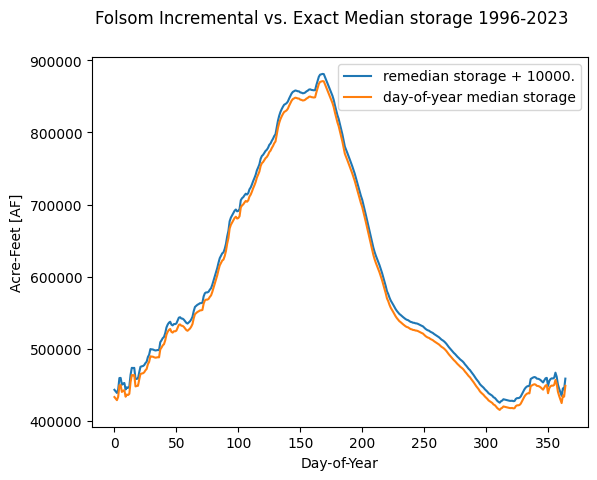

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig,ax=plt.subplots()
ax.plot(range(365),np.array(medians[:-1]) + 10000.,label='remedian storage + 10000.')
ax.plot(range(365),ds.storage_af.groupby(ds.index.dayofyear).median()[:-1],label='day-of-year median storage')
fig.suptitle('Folsom Incremental vs. Exact Median storage 1996-2023')
ax.set_xlabel('Day-of-Year')
ax.set_ylabel('Acre-Feet [AF]')
ax.legend()
plt.show()